In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.signal import argrelextrema
from scipy.special import ndtr
from arch import arch_model

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, TimeSeriesSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    make_scorer, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, RocCurveDisplay, auc, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay, precision_score, recall_score, 
)
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier, plot_importance

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import phik
from phik.report import plot_correlation_matrix
import fAux
import mc_permutation
import detrendPrice 


import ta
from ta.trend import EMAIndicator 
global global_returns
global global_labels

class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, drop_cols):
        self.drop_cols = drop_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.drop_cols)
    
def get_data(ticker, start_date='1999-01-01', end_date=None, save_csv=False):
    os.makedirs("data", exist_ok=True)
    filename = f"data/{ticker.lower()}.csv"
    # if os.path.exists(filename):
    #     print(f"Data for {i} already exists, skipping download.")
    #     continue

    data = yf.download(ticker.upper(), start=start_date, end=end_date, auto_adjust=True)

    # Handle empty or failed download
    if data.empty:
        print(f"No data found for {ticker}")
        return pd.DataFrame()
    
    # Flatten column headers if it's a MultiIndex (e.g., from group_by='ticker')
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    
    data['Ticker'] = ticker.lower()
    data.index = pd.to_datetime(data.index)
    data.columns = [col.lower() for col in data.columns]


    if save_csv:
        data.to_csv(filename, index=False)
        print(f"Saved data for {ticker} to {filename}")
        
    return data


In [14]:
# model for longing; trading at open tomorrow (t+1)
# based on today's data (ohlcv and more), decide whether to long tomorrow
# binary target: 1 if price reverts up (above the threshold e.g. gain over 2%) wihtin the next five trading days, 0 otherwise
def create_target_long(df, threshold=0.02, lookahead=5):
    """
    Label as 1 if max return over the next 'lookahead' days is >= threshold.
    Else, label as 0.
    """
    # df = df.reset_index().rename(columns={'Date': 'date'})
    df['price_tmrw'] = df['open'].shift(-1) # trade at open next day

    df['seq_index'] = range(len(df))
    future_max_list = []
    for i in df['seq_index']:
        if i + 1 + lookahead <= len(df):
            window = df['open'].iloc[i+1 : i+1+lookahead]
            future_max_list.append(window.max())
        else:
            future_max_list.append(np.nan)

    df['future_max'] = future_max_list

    df['future_return'] = (df['future_max'] - df['price_tmrw']) / df['price_tmrw']
    df['target_long'] = (df['future_return'] >= threshold).astype(int)
    df.drop(columns=['seq_index', 'price_tmrw', 'future_max', 'future_return'], inplace=True)
    return df



def feature_engineering(df): # for trading at open tomorrow
    # original_feats = df.columns

    # phase 1: add features thats fundamental to mean reversion trading with bollinger bands and rsi
    df['sma30'] = df['close'].rolling(30).mean()
    df['sma10'] = df['close'].rolling(10).mean()
    df['sma_diff'] = df['sma10'] - df['sma30']
    df['sma_slope'] = df['sma10'].diff()
    df['std30'] = df['close'].rolling(30).std()
    df['bollinger_upper'] = df['sma30'] + 2 * df['std30']
    df['bollinger_lower'] = df['sma30'] - 2 * df['std30']
    df['percent_b'] = (df['close'] - df['bollinger_lower']) / (df['bollinger_upper'] - df['bollinger_lower'])
    df['bollinger_z'] = (df['close'] - df['sma30']) / df['std30']
    df['price_near_lower_bb'] = (df['close'] <= df['bollinger_lower'] * 1.01).astype(int)

    df['rsi14'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()    
    df['prod_bollingerz_rsi'] = df['percent_b'] * df['rsi14']

    df['rsi_smooth'] = df['rsi14'].rolling(3).mean()
    # Detect local lows
    rsi_vals = df['rsi_smooth'].values
    local_lows = argrelextrema(rsi_vals, np.less, order=5)[0]

    df['rsi_local_low'] = 0
    df.iloc[local_lows, df.columns.get_loc('rsi_local_low')] = 1

    # phase 2: add other technical features  
    df['daily_return'] = df['open'].pct_change()
    df['rolling_volatility14'] = df['daily_return'].rolling(window=30).std()
    df['atr'] = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close']).average_true_range()

    # spy_ret5 (discard for now; if wanting to add add it from feature_engineering_add_macro)
    # spy_ret5 = df_spy['close'].pct_change(periods=5)
    # df = df.merge(spy_ret5.rename('spy_ret5'), left_index=True, right_index=True, how='left')

    # phase 3: more features!
    
    # 3.1 GARCH(1,1) on returns
    returns = df['close'].pct_change().dropna() * 100 # in percent
    am = arch_model(returns, vol='Garch', p=1, q=1)
    res = am.fit(disp='off')
    df['garch_vol'] = res.conditional_volatility # in percent

    # 3.2 tiem related features
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['week'] = df.index.isocalendar().week
    df['dayofweek'] = df.index.dayofweek

    # df.dropna(inplace=True)
    # new_feats = [i for i in df.columns if i not in original_feats]
    return df



def feature_engineering_add_macro(df,etf:str):
    df_etf = get_data(etf, end_date = df.index.max())
    df_etf['sma10'] = df_etf['close'].rolling(10).mean()
    df_etf['sma20'] = df_etf['close'].rolling(20).mean()
    df_etf['sma50'] = df_etf['close'].rolling(50).mean()
    df_etf['sma200'] = df_etf['close'].rolling(200).mean()
    df_etf['trend_10_50'] = (df_etf['sma10'] > df_etf['sma50']).astype(int)
    df_etf['trend_20_50'] = (df_etf['sma20'] > df_etf['sma50']).astype(int)
    df_etf['trend_50_200'] = (df_etf['sma50'] > df_etf['sma200']).astype(int)
    df = df.merge(df_etf['trend_10_50'].rename(f'{etf}_trend_10_50'), left_index=True, right_index=True, how='left')
    df = df.merge(df_etf['trend_20_50'].rename(f'{etf}_trend_20_50'), left_index=True, right_index=True, how='left')
    df = df.merge(df_etf['trend_50_200'].rename(f'{etf}_trend_50_200'), left_index=True, right_index=True, how='left')
    return df



def stack_and_ohe_dfs(dfs):
    """
    Takes a dictionary of DataFrames keyed by ticker symbols,
    where each DataFrame has OHLCV data indexed by date.
    Returns a stacked DataFrame with date, OHLCV, and one-hot encoded ticker.
    """
    df_list = []

    for ticker, df in dfs.items():
        temp = df.copy()
        temp = temp.reset_index().rename(columns={'Date': 'date'})  # Ensure 'date' is a column
        temp['ticker'] = ticker
        df_list.append(temp)

    combined_df = pd.concat(df_list, ignore_index=True)

    # ohe each df/ticker
    encoder = OneHotEncoder(sparse_output=False, dtype=int)
    ticker_encoded = encoder.fit_transform(combined_df[['ticker']])
    ticker_df = pd.DataFrame(
        ticker_encoded,
        columns=[f"ticker_{cat}" for cat in encoder.categories_[0]],
        index=combined_df.index
    )

    # concat ohe ticker to original df
    combined_df = pd.concat([combined_df.drop(columns=['ticker']), ticker_df], axis=1)

    return combined_df




def plot_model_metrics(y_true, y_proba):
    y_pred = (y_proba >= 0.5).astype(int)

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[0], colorbar=False)

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_disp.plot(ax=axes[1])

    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    pr_disp.plot(ax=axes[2])

    plt.tight_layout()
    plt.show()


def eval_pipe(X, y, pipe, n_split=5, predict_proba_threshold=0.5):
    '''
    for evaluations on train set, make sure X and y does not contain anything from the test set (future data), 
    and use n_split=5 for 5-fold time series cross-validation
    '''
    tscv = TimeSeriesSplit(n_splits=n_split)
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipe.fit(X_train, y_train)
        y_proba = pipe.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= predict_proba_threshold).astype(int)

        print(f'Fold {i+1}:\n{classification_report(y_test, y_pred)}')

        if i == 0:
            print('Fold 1 visualized below')
            plot_model_metrics(y_test, y_proba)

def pred_proba_to_signal(y_proba, threshold=0.5):
    """
    Convert predicted probabilities to binary signals.
    1 if probability >= threshold, else 0.
    returns a Series of signals.
    """
    return (y_proba >= threshold).astype(int)


def entry_exit(df, use_vol=None, take_profit=1, stop_loss=1): 
    '''
    FOR EACH INSTRUMENT (don't use the aggregated one that contains multiple tickers)
    takes in the X_test or ohlcv dataframe containing model signals,
    returns a df that contains entry and exit dates, prices, returns, and holding days
    use_vol: either 'atr' or 'garch_vol'
    take_profit and stop loss as percentage
    '''
    # if date as index
    if pd.api.types.is_datetime64_any_dtype(df.index): 
        df = df.reset_index().rename(columns={'Date': 'date'})

    trades = []
    i = 0
    n = len(df)
    if use_vol not in [None, 'atr', 'garch_vol']:
        raise ValueError("use_vol must be one of: None, 'atr' or 'garch_vol'")
    
    if use_vol == 'atr':
        multiplier = df['atr']
    elif use_vol == 'garch_vol':
        multiplier = df['garch_vol']
    else:
        multiplier = pd.Series(1, index=df.index)

    while i < n - 6:  # we need at least 5 days ahead, plus trading at open tomorrow
        if df['model_signal'].iloc[i] == 1:
            entry_date = df['date'].iloc[i+1]
            entry_price = df['open'].iloc[i+1]
            exit_price = None
            exit_date = None
            holding = None
            exit_reason = None

            for j in range(1, 6):  # check up to 5 days ahead
                if i + 1 + j >= n:
                    break

                next_price = df['open'].iloc[i + 1 + j]
                ret = (next_price - entry_price) / entry_price

                # Exit Conditions
                if ret >= take_profit * 0.01 * multiplier.iloc[i]:  # profit target
                    exit_price = next_price
                    exit_date = df['date'].iloc[i + 1 + j]
                    holding = j
                    exit_reason = 'profit_target'
                    break
                elif ret <= -stop_loss * 0.01 * multiplier.iloc[i]:  # stop loss
                    exit_price = next_price
                    exit_date = df['date'].iloc[i + 1 + j]
                    holding = j
                    exit_reason = 'stop_loss'
                    break
                elif df['open'].iloc[i + 1 + j] >= df['sma30'].iloc[i + 1 + j]:  # revert to SMA30
                    exit_price = next_price
                    exit_date = df['date'].iloc[i + 1 + j]
                    holding = j
                    exit_reason = 'revert_to_sma30'
                    break

            if exit_price is None:
                # Max holding (5th day)
                exit_price = df['open'].iloc[i + 1 + 5]
                exit_date = df['date'].iloc[i + 1 + 5]
                holding = 5

            trade_return = (exit_price - entry_price) / entry_price
            trades.append({
                'entry_date': entry_date,
                'exit_date': exit_date,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'return': trade_return,
                'holding_days': holding,
                'exit_reason': exit_reason
            })

            i = i + holding  # skip to the day after exit
        else:
            i += 1

    return pd.DataFrame(trades)



def backtest(X_test, model, proba_threshold = 0.5, use_vol=None, take_profit=1, stop_loss=1):
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f'max proba: {y_proba.max()}')
    signals = pred_proba_to_signal(y_proba, threshold=proba_threshold)
    X_test_signal = X_test.assign(model_signal=signals, y_proba=y_proba)

    trades = entry_exit(X_test_signal, use_vol, take_profit, stop_loss)

    total_holding_days = trades['holding_days'].sum()
    total_trading_days = len(X_test_signal)
    holding_time_percentage = total_holding_days/total_trading_days
    n_trades = len(trades)
    n_wins = len(trades[trades['return'] > 0])
    win_rate = n_wins/n_trades

    print(trades['exit_reason'].value_counts()) # 3 possible outcomes: profit_target, stop_loss, revert_to_sma30
    print('holding days spread:')
    print(trades['holding_days'].value_counts())
    print('---')
    print(f"total holding days: {total_holding_days} over {total_trading_days} trading days ({holding_time_percentage:.2%})")
    print(f'number of trades: {n_trades}')
    print(f"win rate: {win_rate:.2%}")
    return trades



def get_cagr(df):
    start_date = df['entry_date'].min()
    end_date = df['exit_date'].max()
    n_years = (end_date - start_date).days / 365.25
    capital = 1
    for r in df['return']:
        capital *= (1 + r)
    cagr = capital ** (1 / n_years) - 1
    return cagr

def get_sharpe(df_trades, total_trading_days):
    ret_mean = df_trades['return'].mean()
    ret_std = df_trades['return'].std()
    n_trades = len(df_trades)
    trades_per_year = (n_trades/total_trading_days) * 252
    return (ret_mean/ret_std) * np.sqrt(trades_per_year)


def check_return_stats(df):
    print(f"check return stats: \n {df['return'].describe()}")
    sns.histplot(df['return'])
    
    



In [3]:
# use top 25 holdings in qqq as of jul 17 2025
qqq_top_25 = ['nvda','msft','aapl','amzn','avgo',
              'meta','nflx','tsla','googl','cost',
              'goog','pltr','csco','amd','tmus',
              'lin','intu','pep','txn','isrg',
              'bkng','qcom','amgn','adbe','amat']

dfs = {i: get_data(i,end_date='2025-07-17') for i in qqq_top_25}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
print(len(dfs))
print(len(dfs['amat']))
print(dfs['amat'].index.min())
print(dfs['amat'].index.max())
dfs['amat'].tail()

25
6674
1999-01-04 00:00:00
2025-07-16 00:00:00


,close,high,low,open,volume,ticker
Date,,,,,,
2025-07-10,198.029999,199.419998,196.649994,198.000000,5229100,amat
2025-07-11,197.929993,198.779999,196.149994,196.850006,4424400,amat
2025-07-14,197.100006,198.820007,194.490005,195.610001,7264000,amat
2025-07-15,199.289993,201.110001,198.500000,200.080002,6007100,amat
2025-07-16,194.809998,195.160004,189.750000,194.000000,9400000,amat


In [5]:
dfs_prep = {}
for key, value in dfs.items():
    dfs_prep[key] = create_target_long(value)
    dfs_prep[key] = feature_engineering(value)
    dfs_prep[key] = feature_engineering_add_macro(value, 'spy')
    dfs_prep[key] = feature_engineering_add_macro(value, 'qqq')
    # dfs_prep[key] = dfs_prep[key].dropna()

df_big = stack_and_ohe_dfs(dfs_prep).dropna()
print(df_big.shape)
# print(df_big.columns)
# print(df_big.isna().sum())
# print(df_big['date'].describe())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

(145271, 57)


In [6]:
train_set = df_big[df_big['year'] <= 2021]
test_set = df_big[df_big['year'] > 2021]
X_train = train_set.drop(columns=['target_long'])
y_train = train_set['target_long']
X_test = test_set.drop(columns=['target_long'])
y_test = test_set['target_long']

In [7]:
# should be reviewed later
drop_feats = [
    'date',
    'high','low','sma30','sma10','std30',
    'bollinger_upper','bollinger_lower',
    'rsi_smooth',
]

ct = make_column_transformer(
    ('drop', drop_feats),  
    remainder='passthrough'  
)

pipe = Pipeline([
    ('ct', ct),
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])


/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:26:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 1:
              precision    recall  f1-score   support

           0       0.60      0.65      0.63     11123
           1       0.54      0.49      0.52      9401

    accuracy                           0.58     20524
   macro avg       0.57      0.57      0.57     20524
weighted avg       0.57      0.58      0.58     20524

Fold 1 visualized below


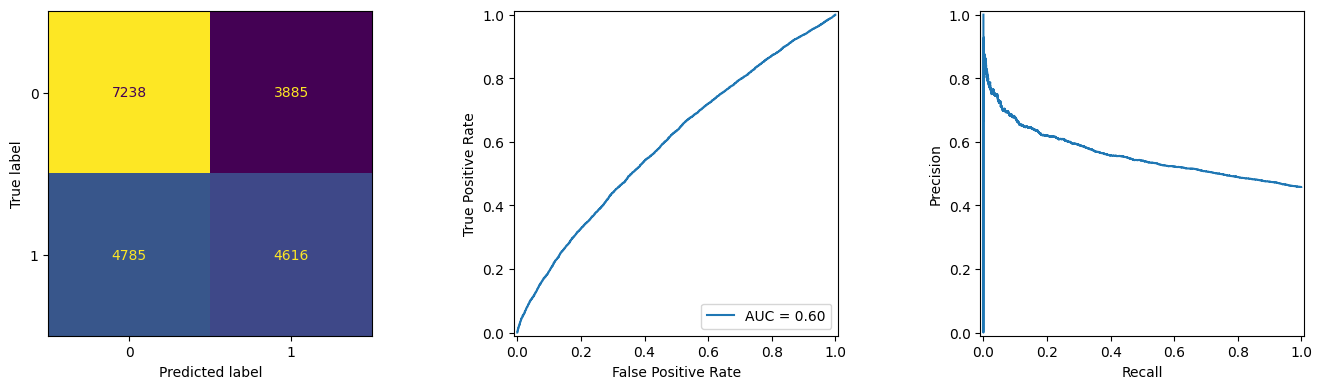

/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:26:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70     12376
           1       0.55      0.54      0.54      8148

    accuracy                           0.64     20524
   macro avg       0.62      0.62      0.62     20524
weighted avg       0.64      0.64      0.64     20524



/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:26:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 3:
              precision    recall  f1-score   support

           0       0.71      0.84      0.77     13325
           1       0.56      0.37      0.44      7199

    accuracy                           0.68     20524
   macro avg       0.64      0.61      0.61     20524
weighted avg       0.66      0.68      0.66     20524



/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:26:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4:
              precision    recall  f1-score   support

           0       0.64      0.80      0.71     11619
           1       0.61      0.41      0.49      8905

    accuracy                           0.63     20524
   macro avg       0.63      0.60      0.60     20524
weighted avg       0.63      0.63      0.62     20524



/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:26:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 5:
              precision    recall  f1-score   support

           0       0.66      0.82      0.73     12064
           1       0.62      0.41      0.49      8460

    accuracy                           0.65     20524
   macro avg       0.64      0.62      0.61     20524
weighted avg       0.64      0.65      0.63     20524



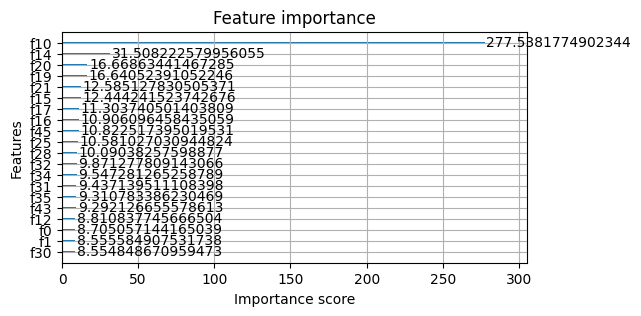

In [8]:
eval_pipe(X_train, y_train, pipe, predict_proba_threshold=0.5)

# check feature importance
fig, ax = plt.subplots(figsize=(6,3)) 
xgb = pipe.named_steps['xgb']
plot_importance(xgb, importance_type='gain', max_num_features=20, ax=ax)
plt.show()

In [9]:
# check feature importance and multicollinearity before dropping any redundant features

In [10]:
# hyperparameter tuning
param_grid = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__n_estimators': [100, 300, 500],
    'xgb__subsample': [0.5, 0.7, 1.0],
    'xgb__colsample_bytree': [0.5, 0.7, 1.0]
}

rscv = RandomizedSearchCV(
    pipe,
    param_distributions=param_grid,
    n_iter=30,  # number of random combinations to try
    scoring='f1',  # or 'roc_auc', 'accuracy', etc.
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Run search
rscv.fit(X_train, y_train)

# Best model
print("Best Parameters:")
print(rscv.best_params_)

print("\nBest Score:")
print(rscv.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:26:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:26:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:26:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:26:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

Best Parameters:
{'xgb__subsample': 1.0, 'xgb__n_estimators': 500, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 0.7}

Best Score:
0.46901269803497014


max proba: 0.9978548884391785
exit_reason
profit_target      3643
stop_loss          3086
revert_to_sma30    1375
Name: count, dtype: int64
holding days spread:
holding_days
1    6623
2     975
3     321
4     132
5     104
Name: count, dtype: int64
---
total holding days: 10584 over 22125 trading days (47.84%)
number of trades: 8155
win rate: 54.57%
---
cagr: 1742.79%
sharpe: 0.41
---
check return stats: 
 count    8155.000000
mean        0.002325
std         0.054658
min        -0.793367
25%        -0.018563
50%         0.004967
75%         0.021083
max         3.608279
Name: return, dtype: float64


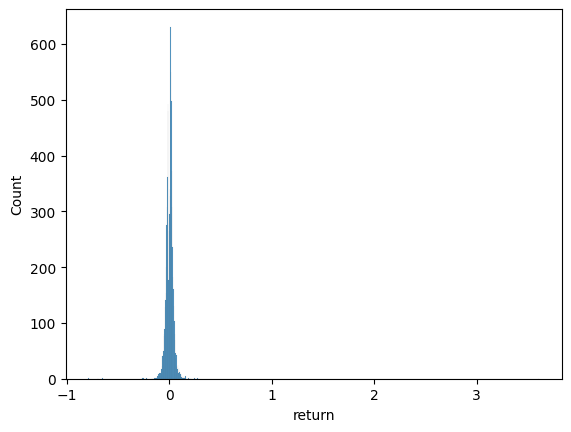

In [11]:
# backtest 1 - aggregated
trades_1 = backtest(X_test, rscv, proba_threshold = 0.5, use_vol = None, take_profit = 1, stop_loss = 1)
print('---')
print(f"cagr: {get_cagr(trades_1):.2%}")
print(f"sharpe: {get_sharpe(trades_1, X_test):.2}")
print('---')
check_return_stats(trades_1)

ticker: aapl
total holding days: 201 over 885 trading days (22.71%)
number of trades: 83
win rate: 62.65%
---
ticker: adbe
total holding days: 298 over 885 trading days (33.67%)
number of trades: 133
win rate: 56.39%
---
ticker: amat
total holding days: 357 over 885 trading days (40.34%)
number of trades: 154
win rate: 57.79%
---
ticker: amd
total holding days: 407 over 885 trading days (45.99%)
number of trades: 185
win rate: 55.68%
---
ticker: amgn
total holding days: 83 over 885 trading days (9.38%)
number of trades: 31
win rate: 58.06%
---
ticker: amzn
total holding days: 238 over 885 trading days (26.89%)
number of trades: 117
win rate: 60.68%
---
ticker: avgo
total holding days: 206 over 885 trading days (23.28%)
number of trades: 116
win rate: 64.66%
---
ticker: bkng
total holding days: 142 over 885 trading days (16.05%)
number of trades: 69
win rate: 57.97%
---
ticker: cost
total holding days: 159 over 885 trading days (17.97%)
number of trades: 87
win rate: 64.37%
---
ticker: 

Text(0, 0.5, 'win rate')

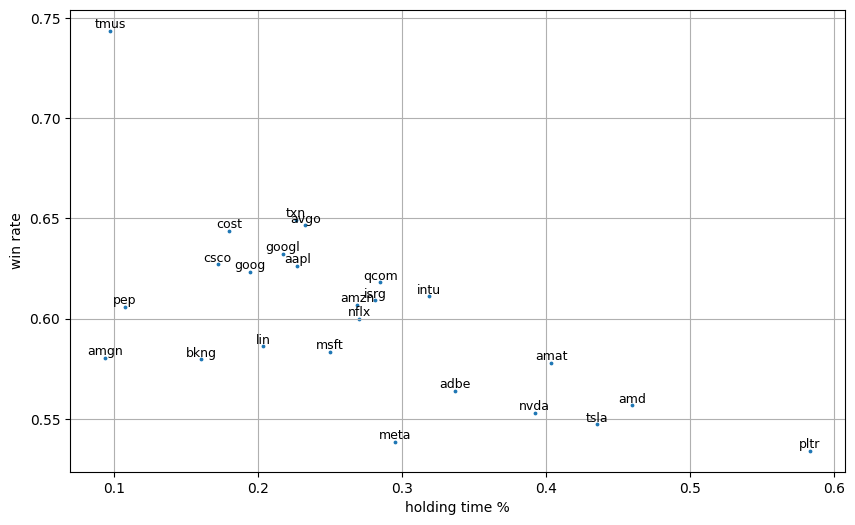

In [12]:
# backtest 2: check individual instrument
y_proba = rscv.predict_proba(X_test)[:, 1]
signals = pred_proba_to_signal(y_proba, threshold=0.7)
X_test_signal= X_test.copy().assign(model_signal=signals, y_proba=y_proba)

ticker_cols = [col for col in X_test_signal.columns if col.startswith('ticker_')]
X_test_signal['ticker'] = X_test_signal[ticker_cols].idxmax(axis=1).str.replace('ticker_', '')
grouped = X_test_signal.groupby('ticker')

total_trades = 0 
total_wins = 0
ls_holding_time_percentage = []
ls_win_rate = []
ls_tickers = []

result_dict = {}

for ticker, group in grouped:
    print(f"ticker: {ticker}")
    ls_tickers.append(ticker)
    trades_df = entry_exit(group, use_vol='garch_vol', take_profit=1.5, stop_loss=1)

    total_holding_days = trades_df['holding_days'].sum()
    total_trading_days = len(group)
    holding_time_percentage = total_holding_days/total_trading_days
    ls_holding_time_percentage.append(holding_time_percentage)

    n_trades = len(trades_df)
    n_wins = len(trades_df[trades_df['return'] > 0])
    win_rate = n_wins/n_trades
    ls_win_rate.append(win_rate)
    
    total_trades += n_trades
    total_wins += n_wins

    result_dict[ticker] = {}
    result_dict[ticker]['trades_df'] = trades_df
    result_dict[ticker]['total_holding_days'] = total_holding_days
    result_dict[ticker]['total_trading_days'] = total_trading_days
    result_dict[ticker]['holding_time_percentage'] = holding_time_percentage
    result_dict[ticker]['n_trades'] = n_trades
    result_dict[ticker]['n_wins'] = n_wins
    result_dict[ticker]['win_rate'] = win_rate
    
    print(f"total holding days: {total_holding_days} over {total_trading_days} trading days ({holding_time_percentage:.2%})")
    print(f'number of trades: {n_trades}')
    print(f"win rate: {win_rate:.2%}")
    print('---')

print(f'total trades: {total_trades}; overall win rate: {(total_wins/total_trades):.2%}')

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(ls_holding_time_percentage, ls_win_rate, s = 3)
for x, y, ticker in zip(ls_holding_time_percentage, ls_win_rate, ls_tickers):
    ax.text(x, y, ticker, fontsize=9, ha='center', va='bottom')
ax.grid(True)
plt.xlabel('holding time %')
plt.ylabel('win rate')

In [18]:
# check cagr and sharpe

print('nvda')
print(f"cagr: {get_cagr(result_dict['nvda']['trades_df'])}")
print(f"sharpe: {get_sharpe(result_dict['nvda']['trades_df'], X_test['ticker_nvda'].sum())}")

nvda
cagr: 0.22374978163339887
sharpe: 0.6720854693253394


---
# WRC & Monte Carlo

White Reality Check p-value: 0.4770
Monte Carlo p-value: 1.0000


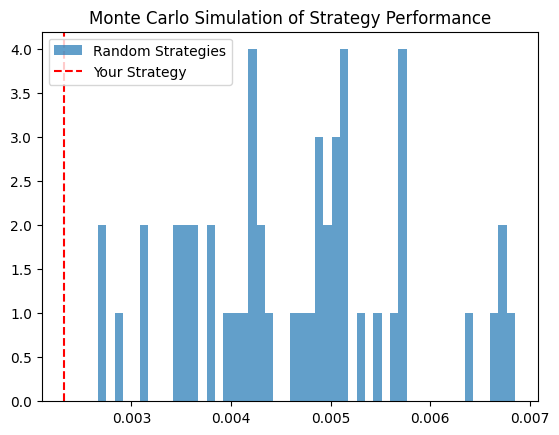

In [20]:
# possibly need to modify becuase it does not consider the multiple-instrument scneario

from statsmodels.tsa.stattools import acf

def white_reality_check(returns, n_bootstraps=1000, block_size=5):
    """
    Returns: array of strategy returns (percent, not log)
    n_bootstraps: number of bootstrap samples
    block_size: block size for stationary bootstrap (to preserve autocorrelation)
    """
    T = len(returns)
    actual_mean = np.mean(returns)
    bootstrapped_means = []

    for _ in range(n_bootstraps):
        # Stationary block bootstrap
        i = 0
        bootstrapped = []
        while i < T:
            start = np.random.randint(0, T)
            block_len = np.random.geometric(1/block_size)
            block = returns[start:start+block_len]
            bootstrapped.extend(block)
            i += block_len
        bootstrapped = bootstrapped[:T]
        bootstrapped_means.append(np.mean(bootstrapped))

    p_value = np.mean([bm >= actual_mean for bm in bootstrapped_means])
    return p_value, actual_mean, bootstrapped_means

pval, actual_avg, dist = white_reality_check(trades_1['return'].values)
print(f"White Reality Check p-value: {pval:.4f}")


# ---

def monte_carlo_simulation(df, n_simulations=1000, lookahead=5):
    simulated_returns = []
    n = len(df)
    for _ in range(n_simulations):
        returns = []
        for _ in range(len(trades_1)):  # simulate same number of trades
            i = np.random.randint(0, n - lookahead - 1)
            try:
                entry = df['open'].iloc[i+1]
                exit = df['open'].iloc[i+1+lookahead]
                ret = (exit - entry) / entry
                returns.append(ret)
            except IndexError:
                continue  # skip if out of bounds
        if returns:  # avoid empty list
            simulated_returns.append(np.mean(returns))
    return simulated_returns


df_mc = X_test[['open']]
sim_returns = monte_carlo_simulation(df_mc, n_simulations=50)
actual_mean = trades_1['return'].mean()
p_value_mc = np.mean([r >= actual_mean for r in sim_returns])
print(f'Monte Carlo p-value: {p_value_mc:.4f}')


plt.hist(sim_returns, bins=50, alpha=0.7, label='Random Strategies')
plt.axvline(actual_mean, color='red', linestyle='--', label='Your Strategy')
plt.title('Monte Carlo Simulation of Strategy Performance')
plt.legend()
plt.show()
